# Define a Single-cathode system

This guide describes how to set up an exemplary single-cathode system programmatically. SIMTRA allows the definition of a sputter system from basic 3D geometries like circles, rectangles, cylinders and cones. Generally, a sputter system always consists of a chamber, one (or multiple) magnetron(s) and one (or multiple) dummy object(s). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysimtra as ps

**Note: before starting, make sure that the SIMTRA application was imported into pySIMTRA**

If not done, use the following method which copies the SIMTRA executable (and some other files cruical for the execution) into the package folder. This only needs to be done ONCE. Calling this method later again will replace the already existing copied files.

In [2]:
# Define the path to the SIMTRA application folder
sim_path = 'C:/Users/Felix/Desktop/simtra_v2.2'
# Import the application into the package
ps.import_exe(sim_path)

## Set up the chamber

The chamber object holds general information about the environment like the temperature and pressure. Either a cylindrical or rectangular chamber can be defined. All units in SIMTRA are SI units. Here we will create a cylindrical chamber with a radius of 120 mm and length of 180 mm.

In [3]:
# Create a cylindrical sputter chamber
ch = ps.Chamber.cylindrical(radius=0.12, length=0.18, temperature=293, pressure=0.5)

## Set up the magnetron/cathode

The `Magnetron` object holds further parameters of the deposition, like the transported element and the number of particles to simulate. Its geometry is defined via a `DummyObject`, which needs to be built from individual surfaces. Here, we build a standard axialsymmetric magnetron with a circular target from two circles, a cylinder and a cone. Every 3D object (`Surface` or `DummyObject`) always needs to have a position and orientation. If none are defined, it is assumed that `position=(0, 0, 0)` and `orientation=(0, 0, 0)`. When defining the `Magnetron` object, the index of the surface to sputter from needs to be defined via the `sputter_surface_index parameter`. Note here that this value starts at 1 (in contrast to the Python standard) in order to be consistent with *SIMTRA*. 

In [14]:
# Construct the magnetron with a 2 inch target from a few simple surfaces
target = ps.Circle(name='target', radius=0.0191, position=(0, 0, 0.055))
shield = ps.Cone(name='shield', small_rho=0.0191, big_rho=0.023, height=0.005, position=(0, 0, 0.055))
cap = ps.Circle(name='cap', radius=0.03, position=(0, 0, 0.06))
cap.perforate(by='circle', radius=0.023)
body = ps.Cylinder(name='body', radius=0.03, height=0.06)
# Combine all surfaces into a dummy object 
m_object = ps.DummyObject(name='magnetron', surfaces=[target, shield, cap, body])
# Define a path to the racetrack file
r_path = 'racetracks/Pt_racetrack_1.5_inch.txt'
# Finally construct the magnetron
mag = ps.Magnetron(transported_element='Pt', 
                   m_object=m_object, 
                   n_particles=10**8, 
                   sputter_surface_index=1,  # the first surface is the target
                   racetrack_file_path=r_path,
                   max_ion_energy=200)  # eV

## Set up the dummy object(s)

`DummyObject`s are objects without emitting a particle flux. Instead, they allow to track the number of particles hitting their surface. That is why we will define a `DummyObject` to track the number of particles sputtered onto an exemplary substrate. The tracking of the particles can be enabled by setting `save_avg_data=True` and providing an averaging grid by setting `avg_grid`. In this case, the substrate only consists of a single surface.

In [5]:
# Define the size of the substrate (this is reused later when plotting the results)
s_dx, s_dy = 0.05, 0.05  # m, m
# Create a rectangle to track the particles arrival
s_surf = ps.Rectangle(name='subSurface', dx=s_dx, dy=s_dy, save_avg_data=True, avg_grid=(200, 100))
# Wrap the rectangle into a dummy object
sub = ps.DummyObject(name='substrate', surfaces=[s_surf], position=(0, 0, 0.15))

## Define the sputter system

Finally, the `SputterSystem` can be defined from the `Chamber`, `Magnetron` and `DummyObject`(s). Additionally, an output path needs to be provided, to which the simulation results will be saved. 

In [11]:
# Define an output path for the simulation
out_path = 'C:/Users/Felix/Desktop/sim_result'
# Combine chamber, magnetron and substrate into a sputter system
system = ps.SputterSystem(ch, mag, sub, out_path)

## Saving the sputter system

After creation of the system, it can be written to a ".sin" file e.g. to view it in the GUI version of *SIMTRA*:

In [7]:
# Save the Sputter System as a sin file
system.to_sin(path='C:/Users/Felix/Desktop/res.sin')

## Perform a simulation and plot the results

To perform a simulation, only the `simulate()` method needs to be called. As the package is based on a Windows executable, **this part only works on Windows operating systems**.

In [12]:
# Start the simulation
result = system.simulate()

The result of the simulation always has the type `SimulationOutput` and wraps all the outputs provided by SIMTRA. The most important one is the number of deposited particles, but also other ones like the incidence energy or angle are available. For a full list, see the API reference. Here, we first define a meshgrid for the x and y values before plotting the number of deposited particles with `pcolormesh` plot of `matplotlib`. Since the defined magnetron faced the substrate directly, we see a deposition profile with the maximum in the center of the substrate.

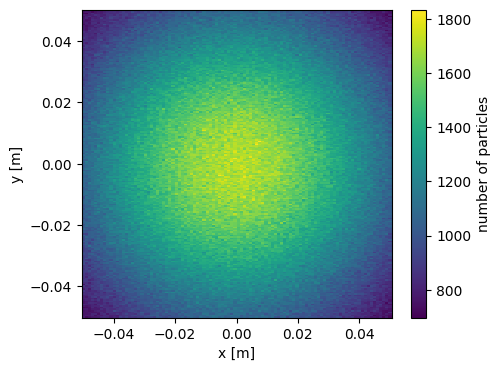

In [13]:
# Get the number of particles sputtered onto the substrate
n_p = result.n_particles['substrate']
# Create a meshgrid for also displaying x and y values
x = np.linspace(-s_dx, s_dx, n_p.shape[1])
y = np.linspace(-s_dx, s_dx, n_p.shape[0])
X, Y = np.meshgrid(x, y)

# Plot the particle distribution as a 2D image
fig, ax = plt.subplots(figsize=(5, 4))
pc = ax.pcolormesh(X, Y, n_p)
# Add axes labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# Add a colorbar
fig.colorbar(pc, ax=ax, label='number of particles')
plt.show()

This guide showed how a single-cathode sputter system can be defined with `pySIMTRA`. However, the real potential of the package is the parallel execution of multiple SIMTRA simulations at the same time. This makes it possible to simulate multi-cathode systems with no time overhead. To learn more about how to define such a multi-cathode system in `pySIMTRA`, see the next section.